In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
import readdy_learn.generate.generate_tools.kinetic_monte_carlo as kmc

if False:
    mpl.rcParams['xtick.labelsize'] = 48
    mpl.rcParams['ytick.labelsize'] = 48

    mpl.rcParams['xtick.major.pad'] = 10
    mpl.rcParams['ytick.major.pad'] = 5

    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 2
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1

    mpl.rcParams['ytick.major.size'] = 14
    mpl.rcParams['ytick.major.width'] = 2
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1

    mpl.rc('font',**{'size':48, 'family':'serif','serif':['Arial']})
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

    mpl.rc('legend', fontsize=30)


mpl.rcParams['figure.figsize'] = (15, 15)
import matplotlib.pyplot as plt

In [2]:
noise_variance = 1.0
desired_rates = np.array([2e-2, 2e-2, 1e-2, 1e-4, 1e-4, 0,0,0,0,0,0,0,0,0,0, 0,0,0])
initial_states = [
    [52, 42, 81, 7], [30,  5, 16, 47], [50, 5, 10,  10], [16, 53,  7, 40],  
    [12, 11,  7, 87], [30,  5, 16, 47], [ 5, 12,  8, 72], [52, 42, 81, 7 ], 
    [55, 32, 79, 24], [48, 39, 29,  5], [ 8, 83, 77, 32], [16, 55, 94, 78],
    [48,  5, 44, 10]
]
initial_states = [np.array([arr]) for arr in initial_states]
n_species=4

In [3]:
ld_derivative_config = {
                'ld_derivative_atol': 1e-7,
                'ld_derivative_rtol': None,
                'ld_derivative_linalg_solver_maxit': 100000,
                'ld_derivative_alpha': 1e-1,
                'ld_derivative_solver': 'spsolve',
                'ld_derivative_linalg_solver_tol': 1e-14,
                'ld_derivative_use_preconditioner': False
            }
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(diffusivity=[[[0.]], [[0.]], [[0.]], [[0.]]], n_species=n_species, n_boxes=1,
                                      init_state=init_state, species_names=["A", "B", "C", "D"])
    sys.add_conversion("A", "D", np.array([desired_rates[0]]))
    sys.add_conversion("D", "A", np.array([desired_rates[1]]))
    sys.add_conversion("D", "B", np.array([desired_rates[2]]))
    sys.add_fusion("A", "B", "C", np.array([desired_rates[3]]))
    sys.add_fission("C", "D", "B", np.array([desired_rates[4]]))

    return sys
def get_bfc():
    bfc = basis.BasisFunctionConfiguration(n_species)
    bfc.add_conversion(0, 3)  # A -> D
    bfc.add_conversion(3, 0)  # D -> A
    bfc.add_conversion(3, 1)  # D -> B
    bfc.add_fusion(0, 1, 2)  # A + B -> C
    bfc.add_fission(2, 3, 1) # C -> D + B
    
    # respective backwards reactions
    bfc.add_conversion(1, 3) # B -> D, nope
    bfc.add_fission(2, 0, 1) # C -> A + B, nope
    bfc.add_fusion(3, 1, 2)  # D + B -> C, nope
    
    # some more stuff
    bfc.add_conversion(0, 1) # A -> B, nope
    bfc.add_conversion(1, 0) # B -> A, nope
    
    bfc.add_conversion(0, 2) # A -> C, nope
    bfc.add_conversion(2, 0) # C -> A, nope
    
    bfc.add_conversion(1, 2) # B -> C, nope
    bfc.add_conversion(2, 1) # C -> B, nope
    
    bfc.add_fusion(0, 2, 3) # A + C -> D, nope
    bfc.add_fission(3, 0, 2) # D -> A + C, nope
    
    bfc.add_fusion(0, 3, 2) # A + D -> C, nope
    bfc.add_fission(2, 0, 3) # C -> A + D, nope
    
    assert bfc.n_basis_functions == len(desired_rates), \
        "got {} basis functions but only {} desired rates".format(bfc.n_basis_functions, len(desired_rates))
    return bfc
def plot_cv_results(cv, mainscore=0, best_params_ix_l1=1.):
    xs = {}
    ys = {}
    allys = {}
    for r in cv.result:
        l1_ratio = r['l1_ratio']
        if len(r['scores']) > 0:
            if l1_ratio in xs.keys():
                xs[l1_ratio].append(r['alpha'])
                ys[l1_ratio].append(r['scores'][mainscore])
                allys[l1_ratio].append(r['scores'])
            else:
                xs[l1_ratio] = [r['alpha']]
                ys[l1_ratio] = [r['scores'][mainscore]]
                allys[l1_ratio] = [r['scores']]
    f, ax = plt.subplots(figsize=(20, 20))
    for l1_ratio in xs.keys():
        l1xs = np.array(xs[l1_ratio])
        l1ys = np.array(ys[l1_ratio])
        l1allys = np.array([np.array(arr) for arr in allys[l1_ratio]]).T
        sorts = np.argsort(l1xs)
        l1xs = l1xs[sorts]
        l1ys = l1ys[sorts]
        
        l1allys = [arr[sorts] for arr in l1allys]
        if l1_ratio == best_params_ix_l1 or best_params_ix_l1 is None:
            ax.plot(l1xs, -l1ys, label='score l1={}'.format(l1_ratio))
            
            for ix, _ys in enumerate(l1allys):
                if np.argmin(-_ys) != 0:
                    # print("found one: {} with argmin {}".format(ix, np.argmin(_ys)))
                    pass
                # ax.plot(l1xs, -_ys, label='test set {}'.format(ix))
                pass
    f.suptitle('Cross-validation scores')
    ax.set_ylabel('score')
    ax.set_xlabel('$\\alpha$')
    plt.legend()
    plt.show()
def plot_rates_bar(desired_rates, estimated_rates):
    assert len(desired_rates) == len(estimated_rates)
    N = len(desired_rates)
    ind = np.arange(N)
    width = .35
    fig, ax = plt.subplots()
    bar1 = ax.bar(ind, desired_rates, width, color='blue')
    bar2 = ax.bar(ind+width, estimated_rates, width, color='green')
    ax.set_xticks(ind + width / 2)
    ax.legend((bar1[0], bar2[0]), ('Desired', 'Estimated'))
    ax.set_xticklabels(["{}".format(i) for i in ind])
    plt.show()
def best_params(cv, scoreidx=None):
    current_best_score = -1
    alpha = -1
    l1_ratio = -1
    
    for r in cv.result:
        if len(r['scores']) > 0:
            if scoreidx is None:
                currscore = np.mean(r['scores'])
            else:
                currscore = r['scores'][scoreidx]
            if current_best_score >= 0:
                if -currscore < current_best_score:
                    current_best_score = -currscore
                    alpha = r['alpha']
                    l1_ratio = r['l1_ratio']
            else:
                current_best_score = -currscore
                alpha = r['alpha']
                l1_ratio = r['l1_ratio']
    return alpha, l1_ratio, current_best_score
def do_the_cv(analysis, n, alphas, l1_ratios, tol=1e-12, solvetol=1e-15, plot_cv_for=None, best_params_ix=None,
              best_params_ix_l1=None):
    cv_n = analysis.elastic_net(n, alphas, l1_ratios, tol=tol)
    if plot_cv_for is not None:
        plot_cv_results(cv_n, mainscore=plot_cv_for, best_params_ix_l1=best_params_ix_l1)
    alpha, l1_ratio, score = best_params(cv_n, best_params_ix)
    print("params: alpha={}, l1={} with corresponding score {}".format(alpha, l1_ratio, score))
    cutoff = 1e-8
    rates = analysis.solve(n, alpha, l1_ratio, tol=solvetol, recompute=True)
    rates[np.where(rates <= cutoff)] = 0
    return rates

In [4]:
analysis = ana.ReactionAnalysis(get_bfc(), desired_rates, initial_states, set_up_system,  
                                recompute=False, recompute_traj=False, fname_prefix='gn_500_', 
                                fname_postfix='',  n_species=n_species, target_n_counts=500, timestep=5e-4,
                                ld_derivative_config=ld_derivative_config)

In [5]:
analysis.recompute_traj

False

In [ ]:
analysis.obtain_lma_trajectories(130, noise_variance=noise_variance, 
                                 alphas=np.linspace(0.1, 10000, num=8), verbose=False, 
                                 atol=5e-8, maxit=500)

got 500 counts (and 500 corresp. time steps), dt= 0.26


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

found alpha=0.1 to be best with a difference of 0.2577718759098382 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

found alpha=204.17959183673466 to be best with a difference of 0.061760125098140994 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

found alpha=116.71690962099123 to be best with a difference of 0.013316608906921656 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

found alpha=125.04668887963348 to be best with a difference of 0.006557378888993326 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

found alpha=132.1864996727554 to be best with a difference of 0.0007011383496481338 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

found alpha=132.86648165305272 to be best with a difference of 0.0001403016351978481 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

found alpha=133.06076221885198 to be best with a difference of 2.003741194389619e-05 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

found alpha=133.00525348576647 to be best with a difference of 2.5778244961083274e-05 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-08, rtol=?/None'),))

In [ ]:
analysis.plot_derivatives(4)

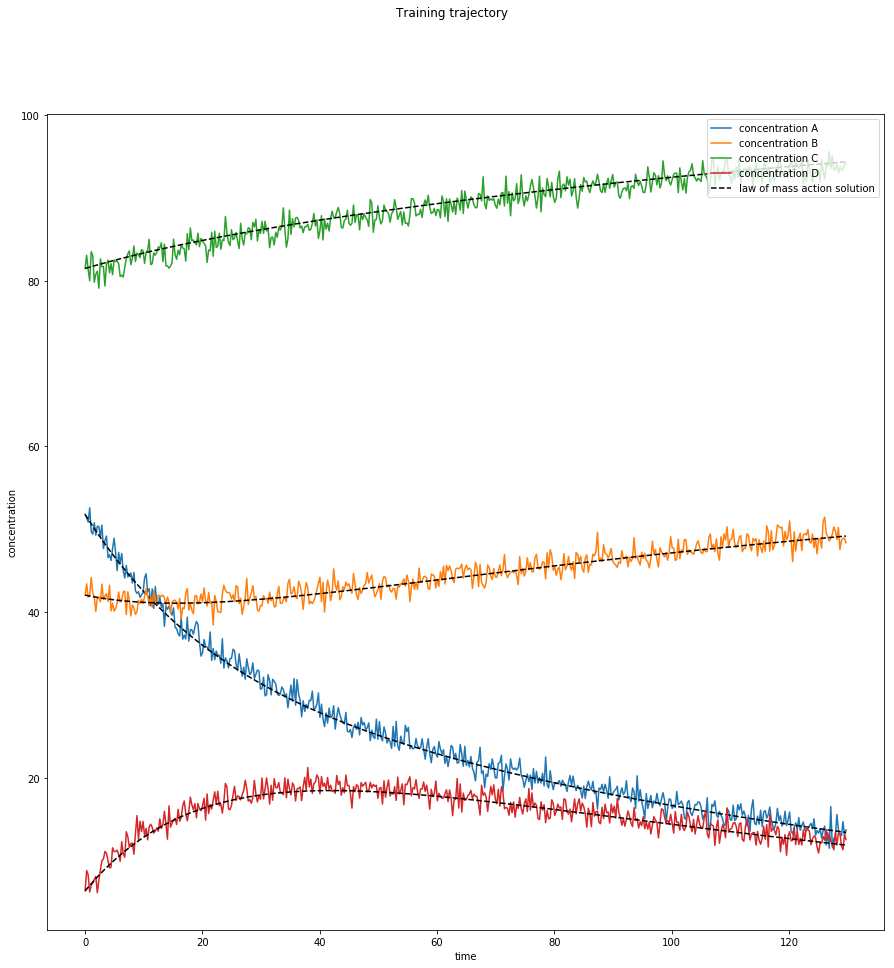

In [18]:
analysis.plot_concentration_curves(0)

In [19]:
alphas = np.linspace(0, .5, num=128)
l1_ratios = np.linspace(0, 1, num=8)

In [20]:
cv0 = analysis.elastic_net(0, alphas, l1_ratios, tol=1e-12)

IntProgress(value=0, max=1023)

In [21]:
def plot_cv_results(cv, mainscore=0):
    xs = {}
    ys = {}
    allys = {}
    for r in cv.result:
        l1_ratio = r['l1_ratio']
        if len(r['scores']) > 0:
            if l1_ratio in xs.keys():
                xs[l1_ratio].append(r['alpha'])
                ys[l1_ratio].append(r['scores'][mainscore])
                allys[l1_ratio].append(r['scores'])
            else:
                xs[l1_ratio] = [r['alpha']]
                ys[l1_ratio] = [r['scores'][mainscore]]
                allys[l1_ratio] = [r['scores']]
    f, ax = plt.subplots(figsize=(20, 20))
    for l1_ratio in xs.keys():
        l1xs = np.array(xs[l1_ratio])
        l1ys = np.array(ys[l1_ratio])
        l1allys = np.array([np.array(arr) for arr in allys[l1_ratio]]).T
        sorts = np.argsort(l1xs)
        l1xs = l1xs[sorts]
        l1ys = l1ys[sorts]
        
        l1allys = [arr[sorts] for arr in l1allys]
        if l1_ratio == 1:
            ax.plot(l1xs, -l1ys, label='score l1={}'.format(l1_ratio))
            
            for ix, _ys in enumerate(l1allys):
                if np.argmin(-_ys) != 0:
                    # print("found one: {} with argmin {}".format(ix, np.argmin(_ys)))
                    pass
                # ax.plot(l1xs, -_ys, label='test set {}'.format(ix))
                pass
    f.suptitle('Cross-validation scores')
    ax.set_ylabel('score')
    ax.set_xlabel('$\\alpha$')
    plt.legend()
    plt.show()

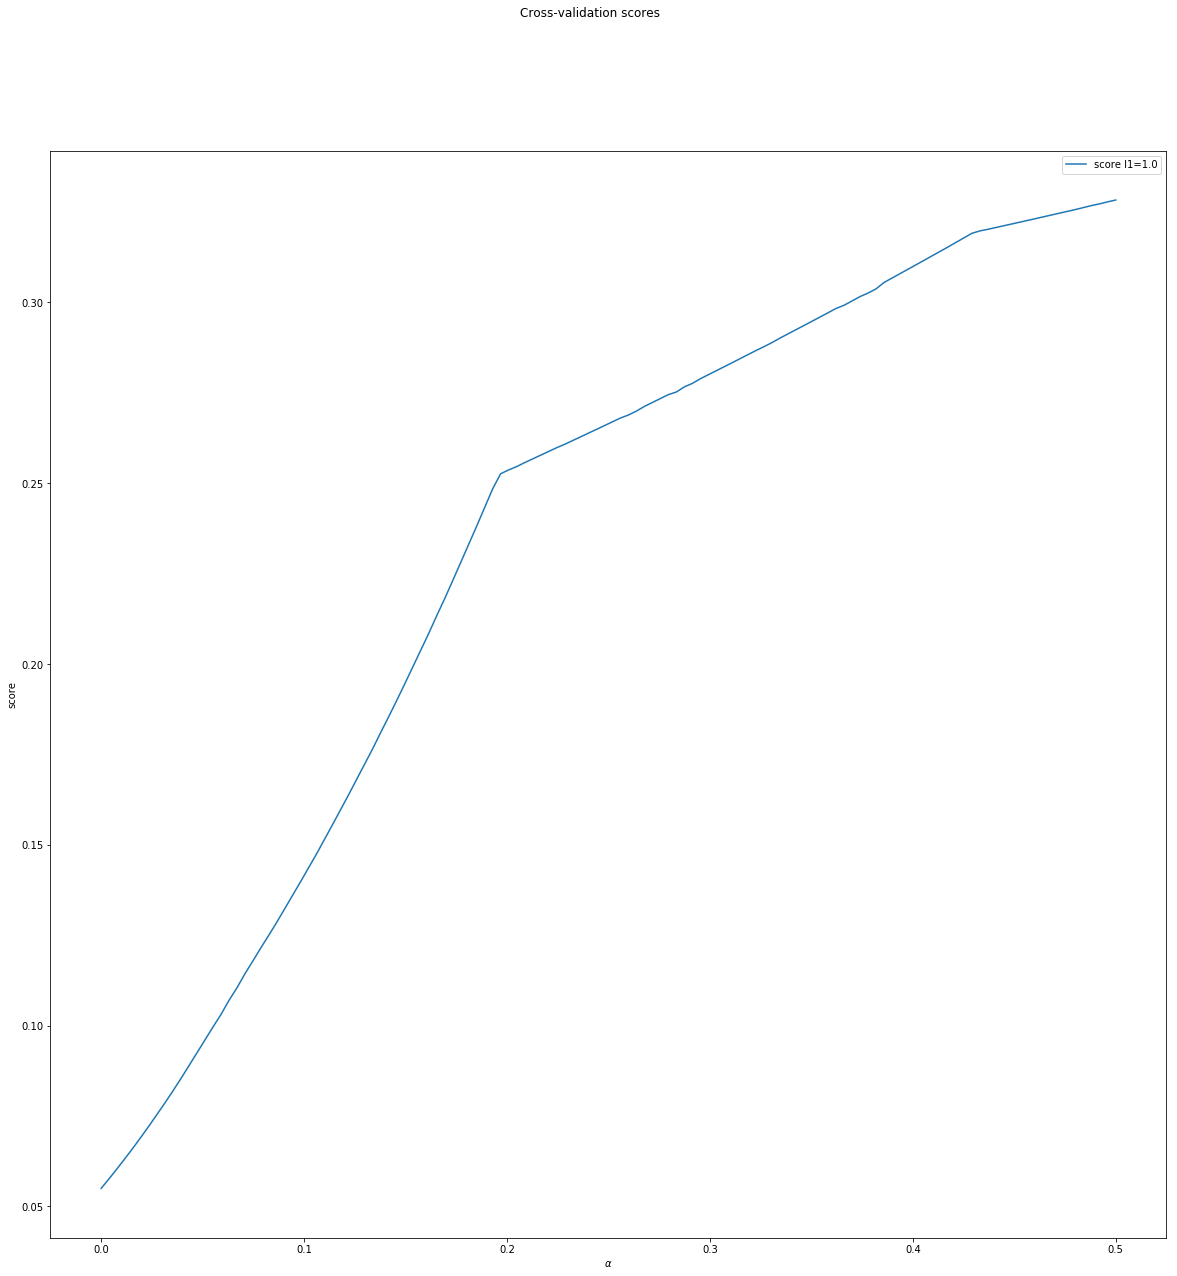

In [30]:
plot_cv_results(cv0, mainscore=5)

In [23]:
def best_params(cv, scoreidx=None):
    current_best_score = -1
    alpha = -1
    l1_ratio = -1
    
    for r in cv.result:
        if len(r['scores']) > 0:
            if scoreidx is None:
                currscore = np.mean(r['scores'])
            else:
                currscore = r['scores'][scoreidx]
            if current_best_score >= 0:
                if -currscore < current_best_score:
                    current_best_score = -currscore
                    alpha = r['alpha']
                    l1_ratio = r['l1_ratio']
            else:
                current_best_score = -currscore
                alpha = r['alpha']
                l1_ratio = r['l1_ratio']
    return alpha, l1_ratio, current_best_score
alpha, l1_ratio, score = best_params(cv0)
print("params: alpha={}, l1={} with corresponding score {}".format(alpha, l1_ratio, score))

params: alpha=0.0, l1=0.0 with corresponding score 0.04102213623434228


In [24]:
alpha, l1_ratio, score = best_params(cv0, None)
print("params: alpha={}, l1={} with corresponding score {}".format(alpha, l1_ratio, score))

params: alpha=0.0, l1=0.0 with corresponding score 0.04102213623434228


In [25]:
cutoff = 1e-8
rates0 = analysis.solve(0, alpha+.1, l1_ratio, tol=1e-15, recompute=True)
rates0[np.where(rates0 <= cutoff)] = 0
print(rates0)

optimization problem did exit successfully (alpha=0.1, lambda=0.0)!
status 0: Optimization terminated successfully.
23 / 30000 iterations
[  1.88550288e-02   1.20140317e-02   8.76846957e-03   8.03882930e-05
   0.00000000e+00   0.00000000e+00   7.92163288e-04   1.28739051e-04
   0.00000000e+00   0.00000000e+00   1.99342915e-04   0.00000000e+00
   0.00000000e+00   3.08440475e-04   0.00000000e+00   5.33901621e-04
   0.00000000e+00   0.00000000e+00]


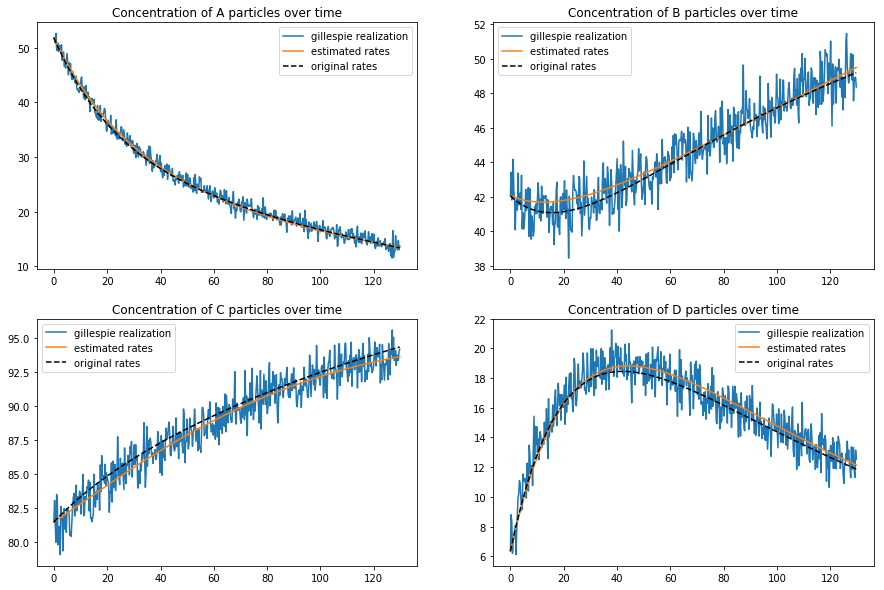

In [31]:
analysis.plot_results(0, rates0)

# CV for traj #0

params: alpha=0.0, l1=0.0 with corresponding score 0.04102213623434228
optimization problem did exit successfully (alpha=0.0, lambda=0.0)!
status 0: Optimization terminated successfully.
25 / 30000 iterations
[  1.88721933e-02   1.20994841e-02   8.79420730e-03   8.01604447e-05
   0.00000000e+00   0.00000000e+00   7.86981628e-04   1.27745501e-04
   0.00000000e+00   0.00000000e+00   2.04056804e-04   0.00000000e+00
   0.00000000e+00   2.98110965e-04   0.00000000e+00   4.96484355e-04
   0.00000000e+00   0.00000000e+00]


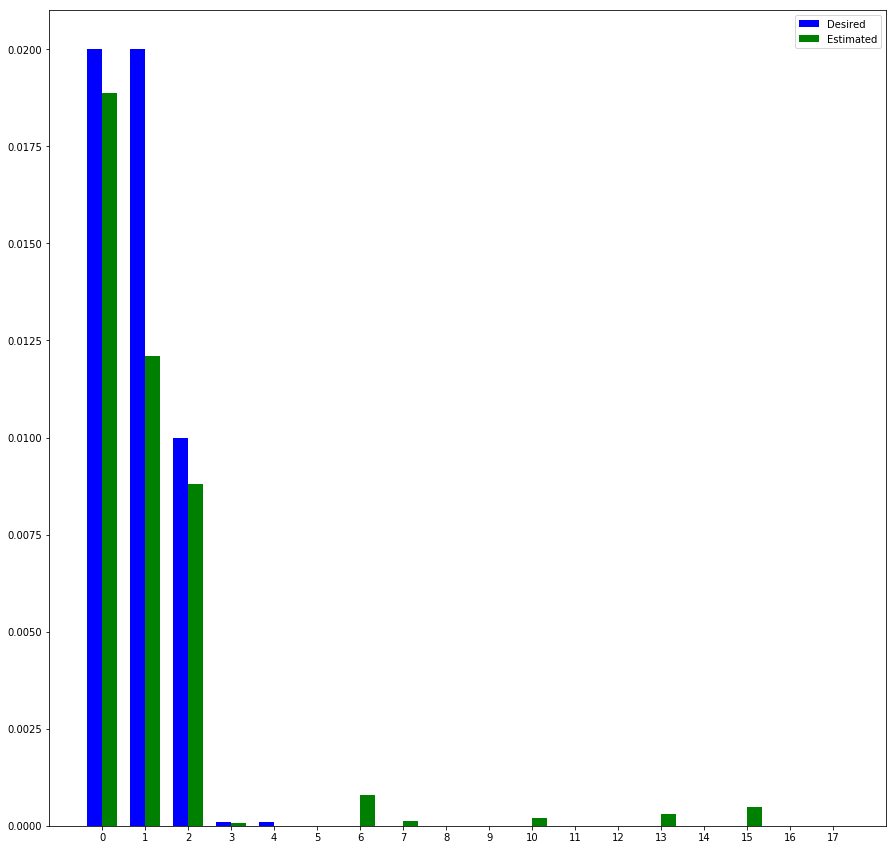

In [26]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 0, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

# CV for traj #1

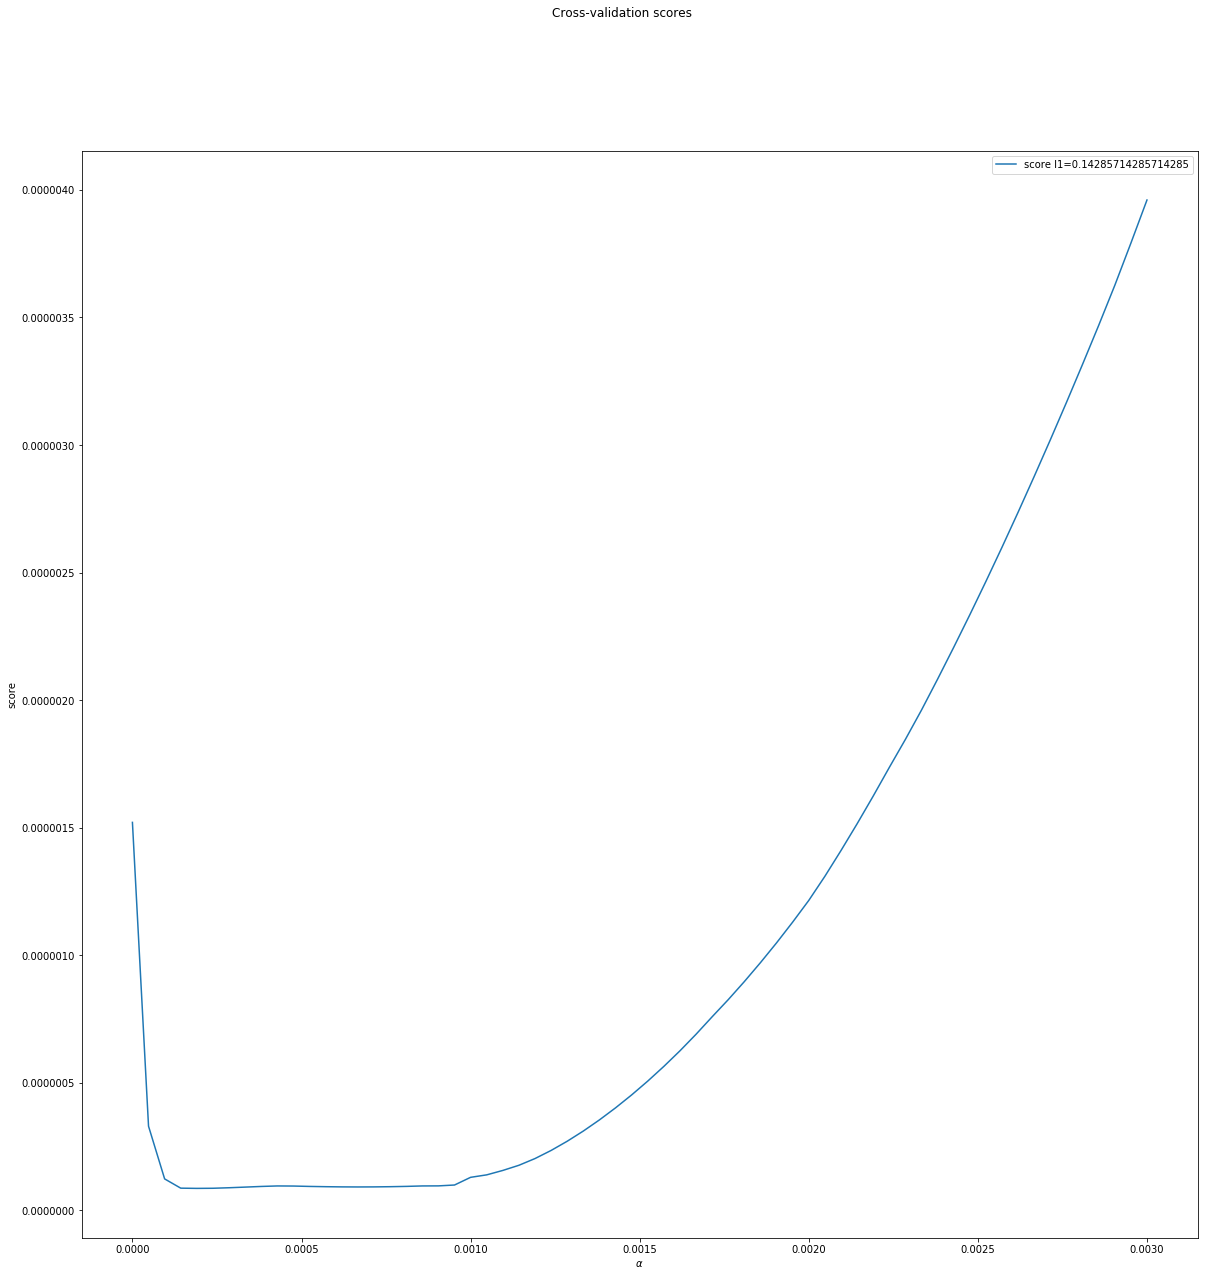

params: alpha=0.00019047619047619048, l1=0.14285714285714285 with corresponding score 8.602901007217646e-08
optimization problem did exit successfully (alpha=0.000190476190476, lambda=0.142857142857)!
status 0: Optimization terminated successfully.
23 / 30000 iterations
[  1.99835058e-02   1.99889113e-02   9.99650247e-03   1.00080506e-04
   1.03183852e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.63269955e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.22057641e-06   0.00000000e+00   1.71451338e-07   2.72004247e-06
   0.00000000e+00   0.00000000e+00]


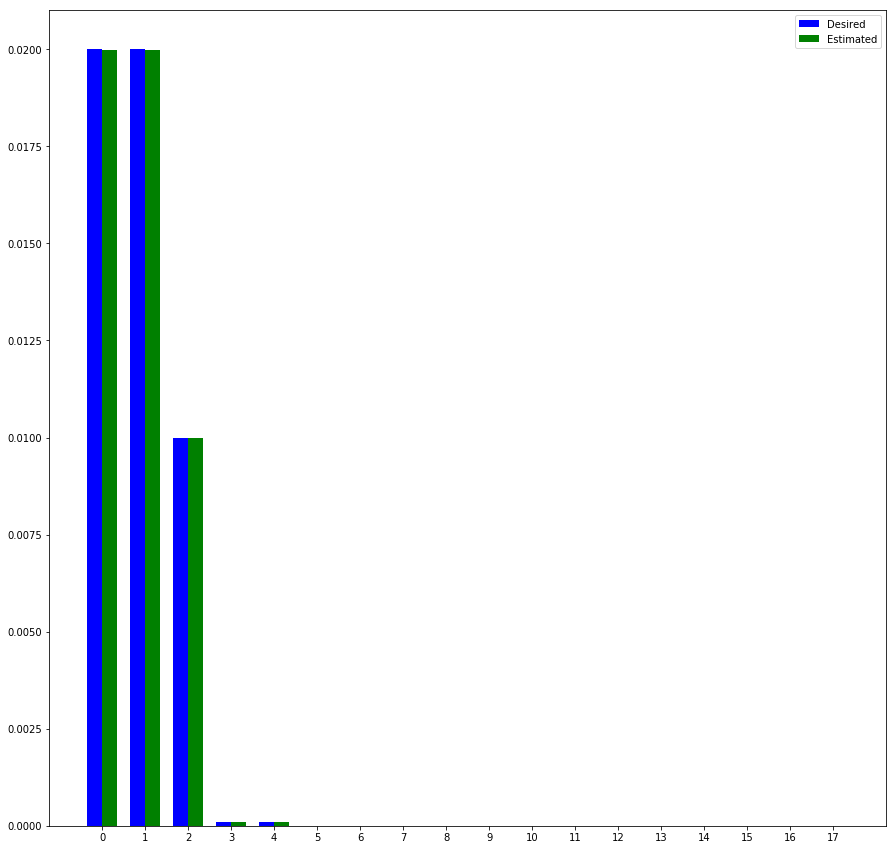

In [57]:
alphas = np.linspace(0, .003, num=64)
l1_ratios = np.linspace(0, 1, num=8)
ix = 6
rates = do_the_cv(analysis, 1, alphas, l1_ratios, tol=5e-16, solvetol=1e-16, plot_cv_for=ix, best_params_ix=ix, 
                  best_params_ix_l1=0.14285714285714285)
print(rates)
plot_rates_bar(desired_rates, rates)

In [56]:
rrates = analysis.solve(1, 0., 1., tol=1e-16, recompute=True)

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
24 / 30000 iterations


# CV for traj #2

IntProgress(value=0, max=2047)

params: alpha=0.0, l1=0.2857142857142857 with corresponding score 9.423279524957939e-07
optimization problem did exit successfully (alpha=0.0, lambda=0.285714285714)!
status 0: Optimization terminated successfully.
23 / 30000 iterations
[  1.99933974e-02   1.99872080e-02   9.99823642e-03   9.96577685e-05
   9.80812176e-05   0.00000000e+00   0.00000000e+00   3.04421793e-07
   0.00000000e+00   0.00000000e+00   1.98616531e-06   0.00000000e+00
   0.00000000e+00   6.99067292e-07   1.14478770e-07   8.06842132e-07
   0.00000000e+00   0.00000000e+00]


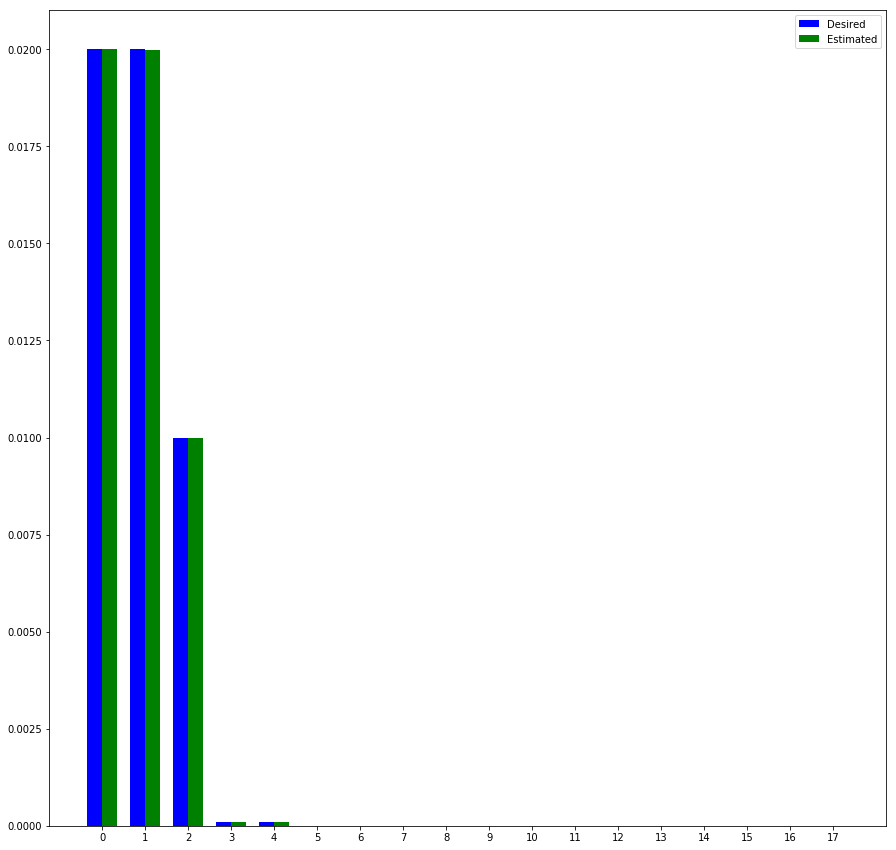

In [43]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 2, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

# CV for traj #3

IntProgress(value=0, max=2047)

params: alpha=0.0, l1=0.0 with corresponding score 3.9525688202493493e-07
optimization problem did exit successfully (alpha=0.0, lambda=0.0)!
status 0: Optimization terminated successfully.
22 / 30000 iterations
[  1.99847149e-02   1.99935803e-02   9.99749890e-03   9.99621683e-05
   1.01591907e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.05307842e-06   0.00000000e+00   1.47283822e-06   0.00000000e+00
   1.57027876e-06   0.00000000e+00   2.96756596e-07   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


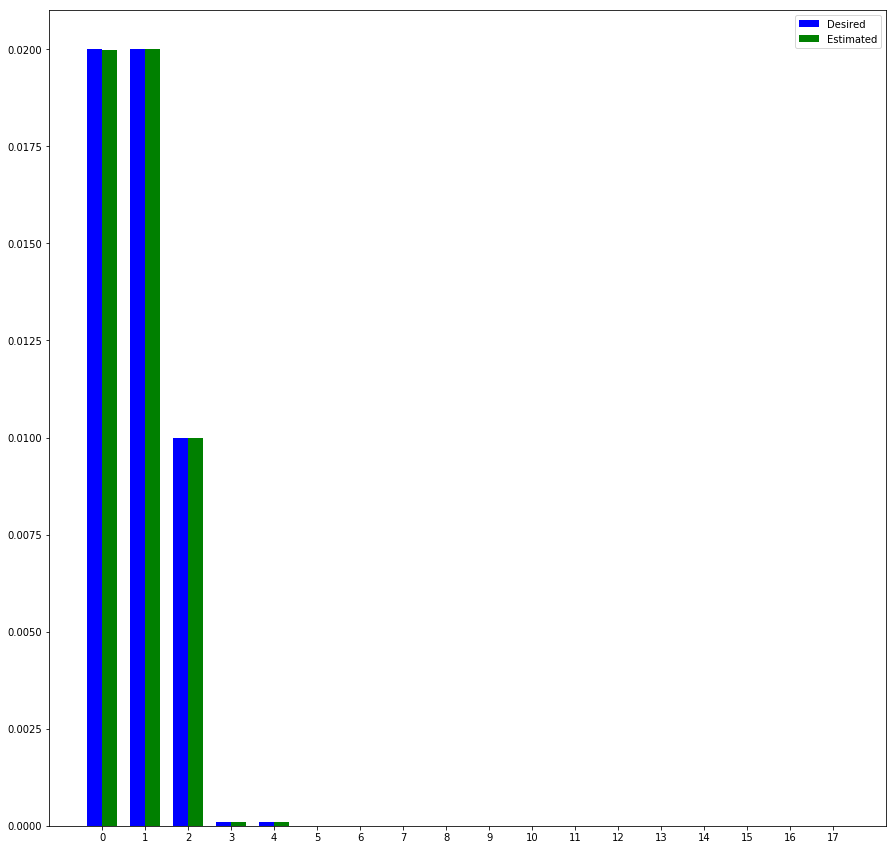

In [44]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 3, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

# CV for traj #4

IntProgress(value=0, max=2047)

no success for alpha=0.2725490196078431, l1_ratio=1.0
status 8: Positive directional derivative for linesearch
22 / 300000 iterations
no success for alpha=0.2980392156862745, l1_ratio=1.0
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success for alpha=0.3137254901960784, l1_ratio=1.0
no success for alpha=0.3137254901960784, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
22 / 300000 iterations
status 8: Positive directional derivative for linesearch
22 / 300000 iterations
no success for alpha=0.3176470588235294, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
22 / 300000 iterations
no success for alpha=0.34509803921568627, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
22 / 300000 iterations
no success for alpha=0.38431372549019605, l1_ratio=0.7142857142857142
status 8: Positive directional derivative for linesearch
22 / 300000 iterations


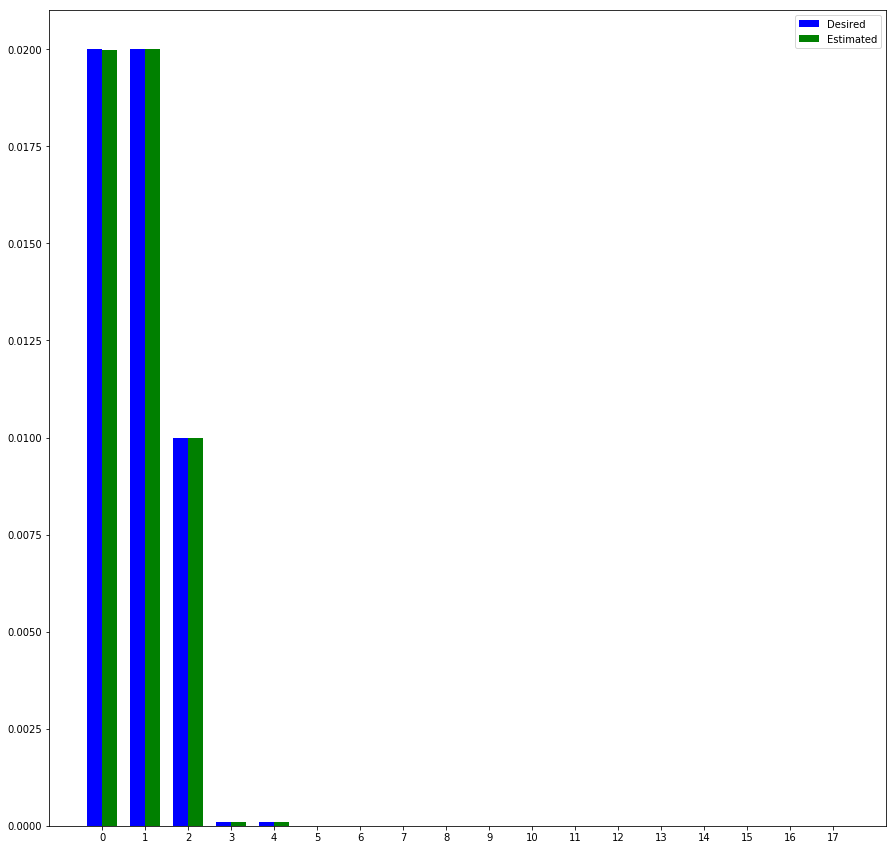

In [45]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 4, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

# CV for traj #5

IntProgress(value=0, max=2047)

no success for alpha=0.3235294117647059, l1_ratio=1.0
status 8: Positive directional derivative for linesearch
22 / 300000 iterations
no success for alpha=0.35490196078431374, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success for alpha=0.3686274509803922, l1_ratio=0.7142857142857142
status 8: Positive directional derivative for linesearch
22 / 300000 iterations
no success for alpha=0.42549019607843136, l1_ratio=1.0
status 8: Positive directional derivative for linesearch
19 / 300000 iterations
no success for alpha=0.45098039215686275, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
19 / 300000 iterations
no success for alpha=0.47058823529411764, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
19 / 300000 iterations
no success for alpha=0.4764705882352941, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
17 / 3

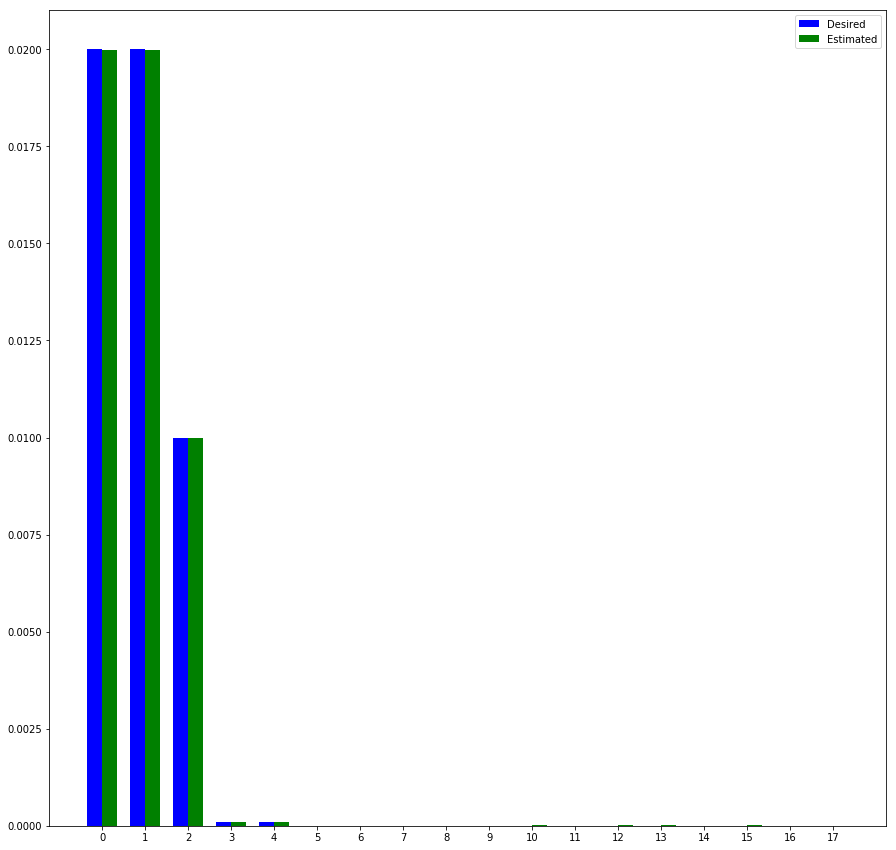

In [46]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 5, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)


# CV for traj #6

IntProgress(value=0, max=2047)

no success for alpha=0.3058823529411765, l1_ratio=1.0
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success for alpha=0.32941176470588235, l1_ratio=1.0
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success for alpha=0.34509803921568627, l1_ratio=1.0
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success for alpha=0.3509803921568627, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success for alpha=0.36666666666666664, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success for alpha=0.37058823529411766, l1_ratio=1.0
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success for alpha=0.3764705882352941, l1_ratio=0.8571428571428571
status 8: Positive directional derivative for linesearch
21 / 300000 iterations
no success fo

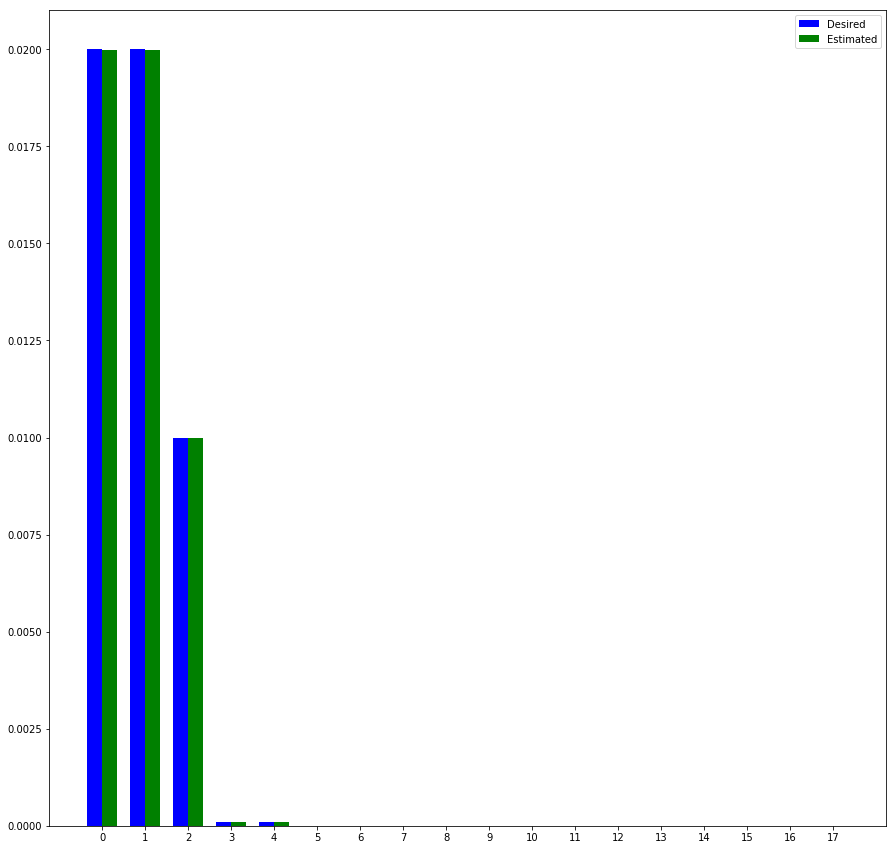

In [47]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 6, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

# CV for traj #7

In [48]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 7, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

IntProgress(value=0, max=2047)

Process ForkPoolWorker-90:
Process ForkPoolWorker-92:
Process ForkPoolWorker-94:
Process ForkPoolWorker-95:
Process ForkPoolWorker-93:
Process ForkPoolWorker-89:
Process ForkPoolWorker-91:
Process ForkPoolWorker-96:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/pytho

  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 292, in function_wrapper
    return function(*(wrapper_args + args))
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/readdy_learn-0.0.1-py3.6-linux-x86_64.egg/readdy_learn/analyze/estimator.py", line 175, in fit_trajs
    options=options)
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/scipy/optimize/slsqp.py", line 402, in _minimize_slsqp
    g = append(fprime(x), 0.0)
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/readdy_learn-0.0.1-py3.6-linux-x86_64.egg/readdy_learn/analyze/estimator.py", line 175, in fit_trajs
    options=options)
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/readdy_learn-0.0.1-py3.6-linux-x86_64.egg/readdy_learn/analyze/estimator.py", line 99, in fit
    return self.fit_trajs(X)
  File "/srv/public

  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 292, in function_wrapper
    return function(*(wrapper_args + args))
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/readdy_learn-0.0.1-py3.6-linux-x86_64.egg/readdy_learn/analyze/estimator.py", line 233, in compute_cv_result_cross_trajs
    estimator.fit(None)
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/readdy_learn-0.0.1-py3.6-linux-x86_64.egg/readdy_learn/analyze/estimator.py", line 164, in objective
    obj = opt.elastic_net_objective_fun(x, self.alpha, self.l1_ratio, large_theta, expected)
KeyboardInterrupt
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/readdy_learn-0.0.1-py3.6-linux-x86_64.egg/readdy_learn/analyze/estimator.py", line 99, in fit
    return self.fit_trajs(X)
KeyboardInterrupt
  File "/srv/public/clonker/miniconda3/envs/readdy_learn/li

KeyboardInterrupt: 

# CV for traj #8

In [ ]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 8, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

# CV for traj #9

In [ ]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 9, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

# CV for traj #10

In [ ]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 10, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)

# CV for traj #11

In [ ]:
alphas = np.linspace(0, .5, num=256)
l1_ratios = np.linspace(0, 1, num=8)
rates = do_the_cv(analysis, 11, alphas, l1_ratios, solvetol=1e-16)
print(rates)
plot_rates_bar(desired_rates, rates)